## Project Demo
Here we provide a brief, runnable example of some of the components we've been working on.

### S5 Forecaster Demo (Jan)
The S5 model (https://arxiv.org/abs/2208.04933) is a relatively new network architecture that is strongly grounded in control theory. As a result, we think it could be particularly amenable to use in data-driven control. Here, we demonstrate the training of an S5 model to forecast a simple sine wave.

In [44]:
import torch
import RNNmpc
import matplotlib.pyplot as plt

# NOTE: the time series dtype must be torch.complex128 as the model requires complex values!
t_range = torch.arange(0, 10*torch.pi, step=0.01).to(torch.complex128)
sine_wave = torch.sin(t_range).reshape(1,-1) # correct training data shape

# instantiate model params
n_in = 1
n_hidden = 32
num_layers = 6
fcast_steps = 2
delta = 0.01
params = (n_in, n_hidden, num_layers, fcast_steps, delta)

# instantiate model
s5_model = RNNmpc.Forecasters.s5_forecaster.S5Forecaster(params)

The next cell could take a while to run as the model trains (~10 mins on M2 Macbook Air CPU). If you're just interested in seeing the output and not correctness, you can manually decrease num_epochs.

In [45]:
num_epochs = 100
lr = 0.001 # learning rate
lags = 52 # sequence length of input used to generate forecast

RNNmpc.Forecasters.s5_forecaster.train_model(s5_model, sine_wave, lr, lags, num_epochs)

/home/cse583/anaconda3/envs/py310/lib/python3.10/site-packages/torch/_tensor.py:1151: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


Epoch: 0
Val. Loss: 0.5283402655333237
Epoch: 1
Val. Loss: 0.10880008917130012
Epoch: 2
Val. Loss: 0.08108487089365667
Epoch: 3
Val. Loss: 0.0767067657648295
Epoch: 4
Val. Loss: 0.069009970507105
Epoch: 5
Val. Loss: 0.05403822599157588
Epoch: 6
Val. Loss: 0.015471654886857445
Epoch: 7
Val. Loss: 0.004750004600090904
Epoch: 8
Val. Loss: 0.003601397859506996
Epoch: 9
Val. Loss: 0.0028095633923261743
Epoch: 10
Val. Loss: 0.0021174465786623457
Epoch: 11
Val. Loss: 0.0015421836091633859
Epoch: 12
Val. Loss: 0.001013761411707562
Epoch: 13
Val. Loss: 0.0006245721069049064
Epoch: 14
Val. Loss: 0.0003330124256194666
Epoch: 15
Val. Loss: 0.00016468883007023116
Epoch: 16
Val. Loss: 7.531661935680224e-05
Epoch: 17
Val. Loss: 3.7864845243586774e-05
Epoch: 18
Val. Loss: 1.746291272909808e-05
Epoch: 19
Val. Loss: 9.411280222007182e-06
Epoch: 20
Val. Loss: 6.853780229571061e-06
Epoch: 21
Val. Loss: 6.961370286766583e-06
Epoch: 22
Val. Loss: 4.695167250924671e-06
Epoch: 23
Val. Loss: 5.710432932481309e

Now plotting the (very short) forecast compared to the ground truth for some initial condition.

Text(0, 0.5, 'sine wave')

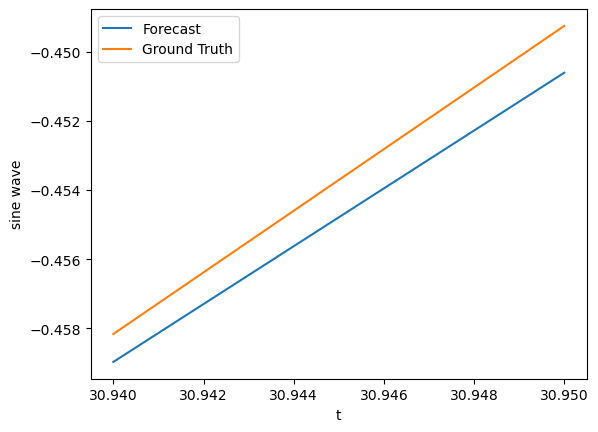

In [49]:
forecast_ic = sine_wave[:, -100:-48].T.reshape(52, 1, 1) # just some initial condition in correct shape
forecast = s5_model.forward(forecast_ic, delta=0.01).detach().numpy()
plt.plot(t_range[-48:-46].real, forecast[:,0,0], label='Forecast')
plt.plot(t_range[-48:-46].real, sine_wave[0, -48:-46].real, label='Ground Truth') # ground truth
plt.legend()
plt.xlabel("t")
plt.ylabel("sine wave")

A couple notes on the model as it is currently implemented:
1. The model is inefficient. The whole point of S5 models is that they can be efficiently parallelized. Unfortunately, PyTorch does not make this parallelization easy. As it stands, the model is too slow to be practically useful. Future directions here likely include offloading the parallelization to Jax or moving to a Jax framework altogether.

2. Due to the time constraints of the project, the model is fairly minimal and there are a variety of hard-coded options that should be decided by the user (batch size during training, for instance). More importantly, the model currently assumes that any control input is constant. This is clearly limiting and does not conform with the API of the other pre-existing models in the package. This too will be addressed in future work.

3. Eagle eyed reviewers will notice that the manner in which the S5Forecaster generates the forecast is not exactly what was proposed in the original paper. A detailed comparison to the true, original architecture is another area of investigation.

### Simulators Demo
The purpose of the simulator classes is to make sure that there is a consistent interface for the MPC algorithm to call from, regardless of the type of simulator or dynamics used.

There are two simulator classes that were developed
1) OdeControl, which uses scipys solve_ivp and can accept any dynamics function that solve_ivp would
2) NeuromancerControl, which employs the simulators built into the neuromancer library and has prebuilt dynamics functions that can be used

A simple spring mass damper system subjected to a sinusoidal forcing will be used to demonstrate the OdeControl class

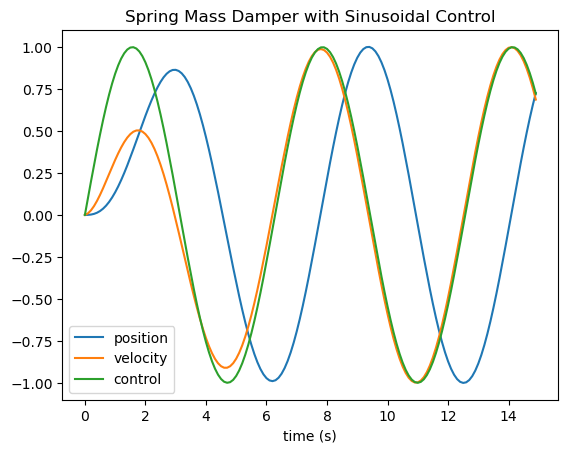

In [48]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from RNNmpc.Simulators.odecontrol import OdeControl


#a simple spring mass damper system for demonstration
def springMassDamper(t,x,u):
    k,c = 1,1
    xdot = np.zeros(np.shape(x))
    xdot[0] = x[1]
    xdot[1] = -k*x[0]-c*x[1]+u[0]
    return xdot

#inital condition and size of control input vector
x0 = torch.tensor([0,0], dtype = torch.float64)
nu = 1

#instatiate simulator with discretization of 0.1
sim = OdeControl(springMassDamper,x0,nu, control_disc = 0.1)

#control input for simulation
Tfinal = 15
dt = 0.1
tvec = np.arange(0,Tfinal,dt)
u = [np.sin(t) for t in tvec]
u = torch.tensor(u, dtype = torch.float64)
u = u.resize(1,len(tvec)) #needs to be a row vector, in general would be size (nu,len(tvec))

#simulate
y = sim.simulate(u,x0)

#plot
plt.figure()
plt.title('Spring Mass Damper with Sinusoidal Control')
plt.plot(tvec, y[0,:], label = 'position')
plt.plot(tvec, y[1,:], label = 'velocity')
plt.plot(tvec,u[0,:], label = 'control')
plt.xlabel('time (s)')
plt.legend()



DuffingControl will be chosen to demonstrate the NeuromancerControl class

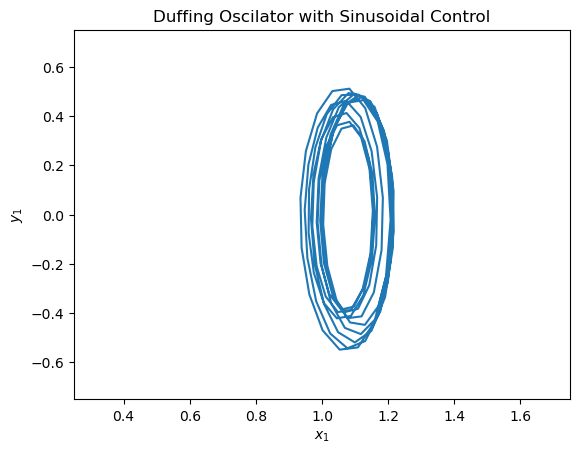

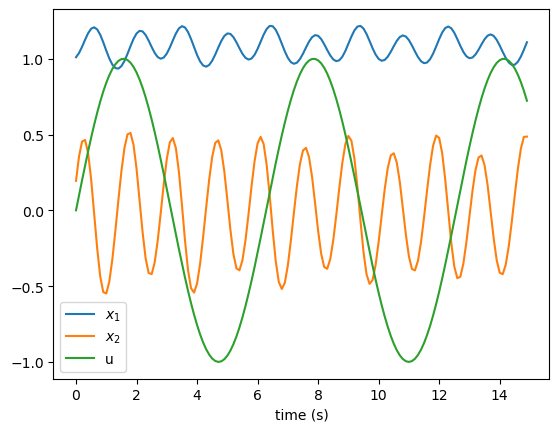

In [47]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from RNNmpc.Simulators.neuromancercontrol import NeuromancerControl
import neuromancer.psl.nonautonomous as nonautonomous

#instantiate simulator with duffing control and discretization of 0.1
sim = NeuromancerControl(nonautonomous.DuffingControl(), control_disc = 0.1)

#initial conditions
x0 = sim.default_x0

#Time controls
Tfinal = 15
dt = 0.1
tvec = np.arange(0,Tfinal,dt)

#control input for simulation
u = [np.sin(t) for t in tvec]
u = torch.tensor(u, dtype = torch.float64)
u = u.resize(1,len(tvec)) #needs to be a row vector, in general would be size (nu,len(tvec))

#simulate
y = sim.simulate(u,x0)

#plot
plt.figure()
plt.title('Duffing Oscilator with Sinusoidal Control')
plt.plot(y[0,:],y[1,:])
plt.xlim(0.25,1.75)
plt.ylim(-0.75,0.75)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$y_1$')

plt.figure()
plt.plot(tvec,y[0,:], label = r'$x_1$')
plt.plot(tvec,y[1,:], label = r'$x_2$')
plt.plot(tvec,u[0,:], label = 'u')
plt.xlabel('time (s)')
plt.legend()


### Closed-loop Simulation with Predictive Control

Introduction:

The `closed_loop_sim` function is a critical component for implementing and analyzing Model Predictive Control (MPC) systems. It simulates the closed-loop interaction between the system (e.g., a physical plant), a predictive model (forecaster), and a reference trajectory that the system aims to follow. This iterative process of prediction, control, and adjustment helps evaluate the system's stability, performance, and response to dynamic changes.

### Functionality
- **Inputs:**
  - **Simulator:** A representation of the system's dynamics, responsible for updating the state based on control inputs.
  - **Forecaster:** A machine learning or model-based system that predicts future states or control signals based on historical data.
  - **Reference Trajectory:** The desired trajectory the system must follow.
  - **Control Horizon & Forecast Horizon:** Parameters defining how far into the future the system predicts and controls.
  - **Number of Steps:** The total number of discrete time steps for simulation.

- **Outputs:**
  - **Control Inputs:** The control signals applied to the system to steer it toward the reference trajectory.
  - **Sensor Outputs:** The states or outputs of the system at each time step, indicating its performance.

### Purpose
The `closed_loop_sim` function is used to:
1. Test the performance of forecasting and control strategies.
2. Validate how well the system tracks the reference trajectory.
3. Explore system behavior under dynamic and uncertain conditions.
4. Prototyping and benchmarking different MPC architectures.

By integrating simulation, prediction, and control into a single workflow, this function accelerates research and development for control systems.

### Demo: Coupled Spring-Mass System with Predictive Control


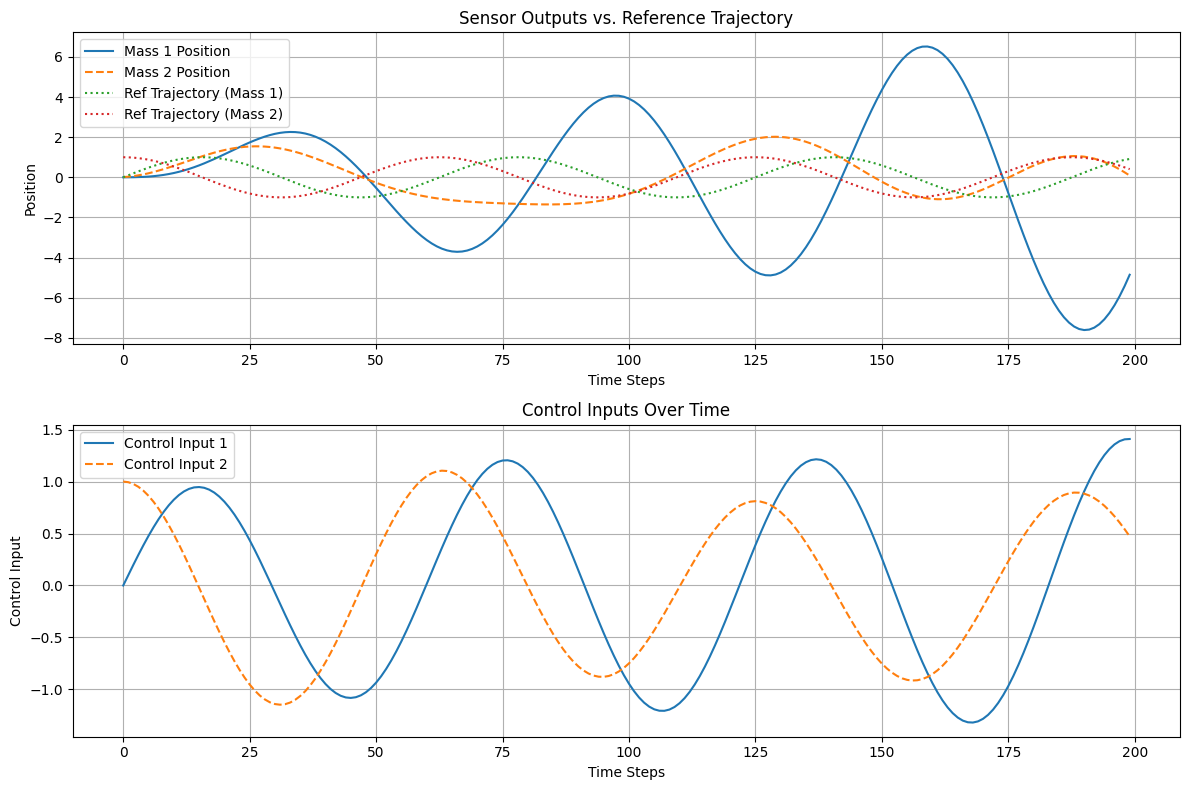

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from RNNmpc.utils import closed_loop_sim


# Example Simulator (Coupled Spring-Mass Dynamics)
def coupled_spring_mass_simulator(state, control_input):
    """
    Simulates two coupled spring-mass systems:
        x1'' = -k1 * x1 + k2 * (x2 - x1) + u1
        x2'' = -k2 * (x2 - x1) + u2
    """
    k1, k2 = 0.5, 0.3  # Spring constants
    damping = 0.05  # Damping factor
    
    # Current positions and velocities
    x1, v1, x2, v2 = state
    u1, u2 = control_input
    
    # Update velocities and positions using Euler's method
    a1 = -k1 * x1 + k2 * (x2 - x1) - damping * v1 + u1
    a2 = -k2 * (x2 - x1) - damping * v2 + u2
    
    v1_new = v1 + a1 * 0.1
    v2_new = v2 + a2 * 0.1
    x1_new = x1 + v1_new * 0.1
    x2_new = x2 + v2_new * 0.1
    
    return np.array([x1_new, v1_new, x2_new, v2_new])

# Example Forecaster
def coupled_spring_forecaster(step, current_state):
    """
    Generates a control signal for a coupled spring-mass system.
    """
    u1 = np.sin(0.1 * step) - 0.1 * current_state[0]
    u2 = np.cos(0.1 * step) - 0.1 * current_state[2]
    return np.array([u1, u2])

# Parameters
num_steps = 200
ref_traj = np.vstack([
    np.sin(np.linspace(0, 20, num_steps)),  # Target trajectory for x1
    np.cos(np.linspace(0, 20, num_steps))  # Target trajectory for x2
]).T  # Reference trajectory for the two positions

# Run Closed-loop Simulation
results = closed_loop_sim(
    simulator=coupled_spring_mass_simulator,
    forecaster=coupled_spring_forecaster,
    ref_traj=ref_traj,
    num_steps=num_steps,
)

# Visualization
plt.figure(figsize=(12, 8))
time = np.arange(num_steps)

# Plot Sensor Outputs
plt.subplot(2, 1, 1)
plt.plot(time, results["sensor_outputs"][:, 0], label="Mass 1 Position", linestyle="-")
plt.plot(time, results["sensor_outputs"][:, 2], label="Mass 2 Position", linestyle="--")
plt.plot(time, ref_traj[:, 0], label="Ref Trajectory (Mass 1)", linestyle="dotted")
plt.plot(time, ref_traj[:, 1], label="Ref Trajectory (Mass 2)", linestyle="dotted")
plt.title("Sensor Outputs vs. Reference Trajectory")
plt.xlabel("Time Steps")
plt.ylabel("Position")
plt.legend()
plt.grid()

# Plot Control Inputs
plt.subplot(2, 1, 2)
plt.plot(time, results["control_inputs"][:, 0], label="Control Input 1", linestyle="-")
plt.plot(time, results["control_inputs"][:, 1], label="Control Input 2", linestyle="--")
plt.title("Control Inputs Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Control Input")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
